# Convullation Neural Network (CNN) with integrated Neural Style Transfer (NST).

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Uvoz potrebnih biblioteka

In [12]:
import tensorflow as tf
print("Verzija korištenog tensorflow: {}".format(tf.__version__))

Verzija korištenog tensorflow: 2.9.2


In [13]:
import matplotlib
import matplotlib.pyplot as plt
print("Verzija korištenog matplotlib: {}".format(matplotlib.__version__))

Verzija korištenog matplotlib: 3.2.2


In [14]:
import numpy as np
print("Verzija korištenog numpy: {}".format(np.__version__))

Verzija korištenog numpy: 1.21.6


In [15]:
import PIL.Image
print("Verzija Pillow Imaging Library (PIL): {}".format(PIL.__version__))

Verzija Pillow Imaging Library (PIL): 7.1.2


In [16]:
import IPython.display as display

In [17]:
import time

## Uvoz slike i skaliranje slike



In [18]:
content_path = "/content/drive/MyDrive/CNN_NST/Slika/mona_lisa.jpg"
style_path = "/content/drive/MyDrive/CNN_NST/Filter/Moran_Grand_Canyon.jpg"
# Style 2
style_path_2 = "/content/drive/MyDrive/CNN_NST/Filter/Hokusai_TGWK.jpg"

In [19]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)

    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

In [20]:
content_image = load_img(content_path)
style_image = load_img(style_path)

## Prikaz uređenih slika

In [21]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

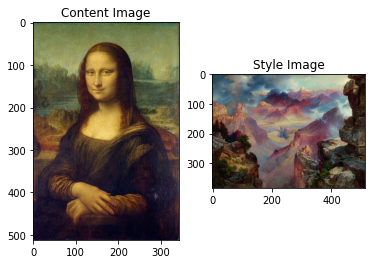

In [22]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [23]:
print("Karakteristike unesene slike su:\n  Tensor: {}   unit,\n  Height: {} pixels,\n  Width:  {} pixels,\n  Depth:  {}   colors\n".format(content_image.shape[0], content_image.shape[1], content_image.shape[2], content_image.shape[3]))

Karakteristike unesene slike su:
  Tensor: 1   unit,
  Height: 512 pixels,
  Width:  343 pixels,
  Depth:  3   colors



In [24]:
print("Karakteristike filter slike su:\n  Tensor: {}   unit,\n  Height: {} pixels,\n  Width:  {} pixels,\n  Depth:  {}   colors\n".format(style_image.shape[0], style_image.shape[1], style_image.shape[2], style_image.shape[3]))

Karakteristike filter slike su:
  Tensor: 1   unit,
  Height: 384 pixels,
  Width:  512 pixels,
  Depth:  3   colors



In [25]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

574710816/574710816 [==============================] - 4s 0us/step


In [26]:
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)

(1, 1000)


In [27]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions( prediction_probabilities.numpy() )[0]

print([(class_name, prob) for (number, class_name, prob) in predicted_top_5])

35363/35363 [==============================] - 0s 0us/step
[('book_jacket', 0.39477023), ('fur_coat', 0.30779472), ('tub', 0.045300443), ('cloak', 0.019894727), ('mosquito_net', 0.01176482)]


In [28]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

80134624/80134624 [==============================] - 0s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [29]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [30]:
content_layers = ['block4_conv2'] 

style_layers = ['block1_conv1',
        'block2_conv1',
        'block3_conv1']

In [31]:
def vgg_layers(layer_names):

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [32]:
style_extractor = vgg_layers(style_layers)

In [33]:
style_outputs = style_outputs = style_extractor(style_image*255)

In [34]:
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  742.46313
  mean:  20.49832

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  3474.05
  mean:  111.42996



In [35]:
def gram_matrix(input_tensor):

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result/(num_locations)

In [36]:
class StyleContentModel(tf.keras.models.Model):

    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                              outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output)  
                            for style_output in style_outputs]
        content_dict = {content_name:value 
            for content_name, value 
            in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value
          for style_name, value
          in zip(self.style_layers, style_outputs)}    
        return {'content':content_dict, 'style':style_dict}

In [37]:
extractor = StyleContentModel(style_layers, content_layers)

In [38]:
results = extractor(tf.constant(content_image))

In [39]:
for name, output in sorted(results['style'].items()):
      print("  ", name)
      print("    shape: ", output.numpy().shape)
      print("    min: ", output.numpy().min())
      print("    max: ", output.numpy().max())
      print("    mean: ", output.numpy().mean())
      print()

   block1_conv1
    shape:  (1, 64, 64)
    min:  2.9838136e-06
    max:  24215.555
    mean:  362.75635

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  58111.953
    mean:  9251.568



In [40]:
for name, output in sorted(results['content'].items()):
       print("  ", name)
       print("    shape: ", output.numpy().shape)
       print("    min: ", output.numpy().min())
       print("    max: ", output.numpy().max())
       print("    mean: ", output.numpy().mean())

   block4_conv2
    shape:  (1, 64, 42, 512)
    min:  0.0
    max:  12828.353
    mean:  244.50041


In [41]:
content_targets = extractor(content_image)['content']

In [42]:
style_targets = extractor(style_image)['style']

In [43]:
style_weight=500
content_weight=1

In [44]:
import torch.optim as optim

opt = tf.optimizers.Adam(learning_rate=0.02) # beta_1=0.99, epsilon=1e-1


#def get_input_optimizer(content_image):
    # this line to show that input is a parameter that requires a gradient
#    optimizer = optim.LBFGS(content_image)
#    return optimizer

#optimizer = get_input_optimizer(content_image)


In [45]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [46]:
image = tf.Variable(content_image)

In [47]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean(
                                (style_outputs[name] - style_targets[name])**2) 
                                for name in style_outputs.keys()] )
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean(
                                (content_outputs[name]-content_targets[name])**2) 
                                 for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [48]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [49]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

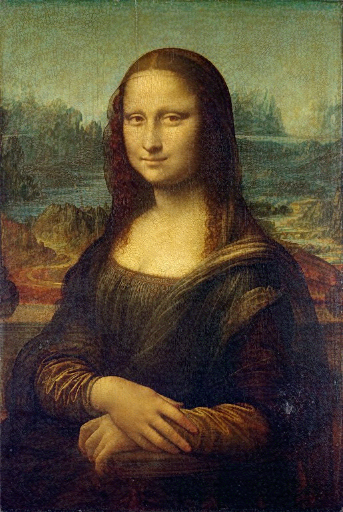

In [50]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

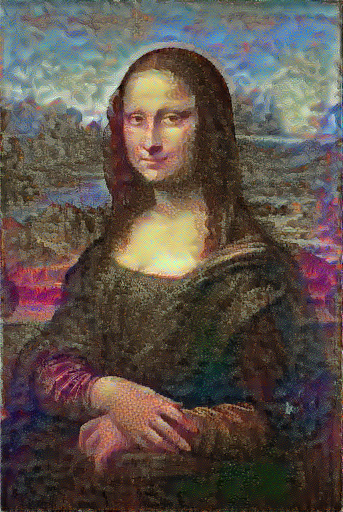

Train step: 300
Total time: 14.9


In [51]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 15

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

AKO NE IZGLEDA DOBRO POKRENI OSTATAK BLOKA

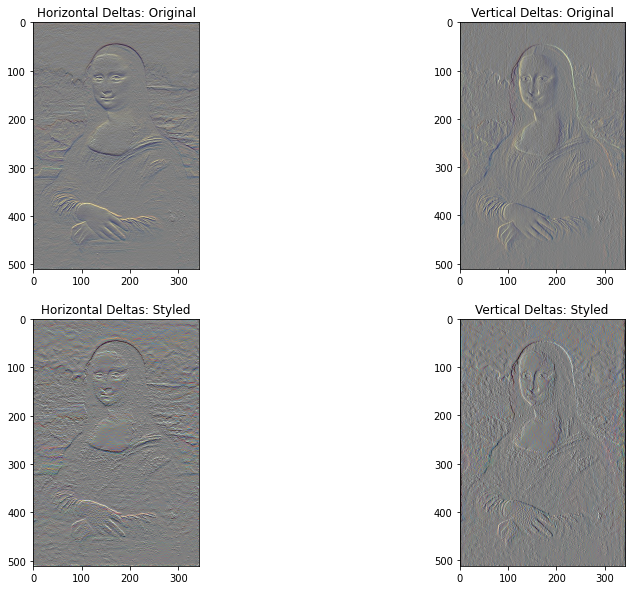

In [52]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

array([61137.316], dtype=float32)

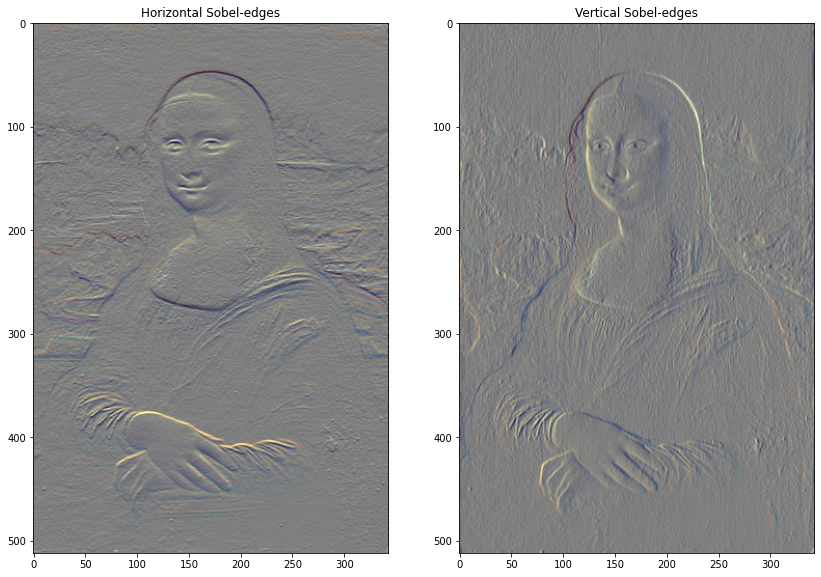

In [53]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()
tf.image.total_variation(image).numpy()

In [54]:
total_variation_weight= 1

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

image = tf.Variable(content_image)

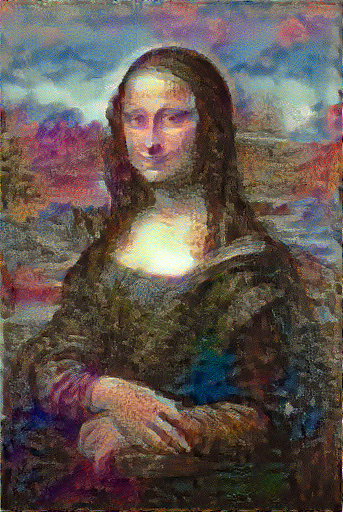

Train step: 2000
Total time: 101.4


In [55]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))